# Download multiple meteoscreening variables

**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# Settings

## Data settings

In [1]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution
SITE_LAT = 47.478333   # CH-LAE
SITE_LON = 8.364389  # CH-LAE

## Imports

In [2]:
from datetime import datetime
from pathlib import Path
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
import diive as dv
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.core.io.files import save_parquet
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.pkgs.corrections.offsetcorrection import remove_relativehumidity_offset, remove_radiation_zero_offset
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.87.0
dbc-influxdb version: v0.13.1
Reading configuration files was successful.
Connection to database works.


</br>

# **Download**

## Data from `diive` meteoscreening (2022-2024)

In [3]:
%%time
data_simple_diive, data_detailed_diive, assigned_measurements_diive = dbc.download(
    bucket=f'ch-lae_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1'],
    start='2022-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2025-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_diive'
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version ['meteoscreening_diive']
    between 2022-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2022-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_47_1" or r["_field"] == "RH_T1_47_1" or r["_field"] == "SW_IN_T1_47_1" or r["_field"] == "LW_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start

In [4]:
data_simple_diive

,LW_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,
2022-01-01 00:30:00,281.339657,89.611768,0.0,8.437600
2022-01-01 01:00:00,280.357413,89.877390,0.0,8.238294
2022-01-01 01:30:00,279.863157,90.451803,0.0,8.044655
2022-01-01 02:00:00,280.836867,89.879497,0.0,8.111550
2022-01-01 02:30:00,280.860203,89.994291,0.0,7.972055
...,...,...,...,...
2024-12-31 22:00:00,232.595527,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,89.921251,0.0,-0.392922


## Data from `mst` meteoscreening (2004-2021)

In [5]:
%%time
data_simple_mst, data_detailed_mst, assigned_measurements_mst = dbc.download(
    bucket=f'ch-lae_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1'],
    start='2004-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2022-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_mst'
)


DOWNLOADING
    from bucket ch-lae_processed
    variables ['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version ['meteoscreening_mst']
    between 2004-01-01 00:00:01 and 2022-01-01 00:00:01
    with timezone offset to UTC of 1
Using querystring:
from(bucket: "ch-lae_processed") |> range(start: 2004-01-01T00:00:01+01:00, stop: 2022-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_mst") |> filter(fn: (r) => r["_field"] == "TA_T1_47_1" or r["_field"] == "RH_T1_47_1" or r["_field"] == "SW_IN_T1_47_1" or r["_field"] == "LW_IN_T1_47_1") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
Used querystring: from(bucket: "ch-lae_processed") |> range(start: 20

In [6]:
data_simple_mst

,LW_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,
2004-09-20 11:00:00,NaN,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,73.400002,NaN,13.980000
...,...,...,...,...
2021-12-31 22:00:00,280.736376,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,281.142280,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,280.816904,95.821067,-9.810373,7.719400


</br>

# Adjust units (if needed)

In [7]:
# # Units for PA from meteoscreening_diive are given in mbar (hPa), but are needed in kPa
# data_simple['PA_GF1_0.9_1'] = data_simple['PA_GF1_0.9_1'].divide(10)
# data_simple

</br>

# Rename variables for merging

In [8]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN': 'PPFD_1_1_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_F': 'Pa_1_1_1'
}
data_simple_diive = data_simple_diive.rename(columns=renaming_dict)
data_simple_diive

,LW_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,
2022-01-01 00:30:00,281.339657,89.611768,0.0,8.437600
2022-01-01 01:00:00,280.357413,89.877390,0.0,8.238294
2022-01-01 01:30:00,279.863157,90.451803,0.0,8.044655
2022-01-01 02:00:00,280.836867,89.879497,0.0,8.111550
2022-01-01 02:30:00,280.860203,89.994291,0.0,7.972055
...,...,...,...,...
2024-12-31 22:00:00,232.595527,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,89.921251,0.0,-0.392922


In [9]:
renaming_dict = {
    'LW_IN_T1_47_1': 'LW_IN_T1_47_1',
    'PPFD_IN_T1_2_2': 'PPFD_1_1_1',
    'RH_T1_47_1': 'RH_T1_47_1',
    'SW_IN_T1_47_1': 'SW_IN_T1_47_1',
    'TA_T1_47_1': 'TA_T1_47_1',
    'PA_GF1_0.9_1': 'Pa_1_1_1'
}
data_simple_mst = data_simple_mst.rename(columns=renaming_dict)
data_simple_mst

,LW_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,
2004-09-20 11:00:00,NaN,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,73.400002,NaN,13.980000
...,...,...,...,...
2021-12-31 22:00:00,280.736376,94.843261,-9.935194,7.933211
2021-12-31 22:30:00,281.142280,93.992424,-10.250348,8.022416
2021-12-31 23:00:00,280.816904,95.821067,-9.810373,7.719400


</br>

# Merge data

In [10]:
# Merge data on index
data_simple_merged = pd.concat([data_simple_diive, data_simple_mst], axis=0)
data_simple_merged = data_simple_merged.sort_index()
data_simple_merged

,LW_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,
2004-09-20 11:00:00,NaN,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,73.400002,NaN,13.980000
...,...,...,...,...
2024-12-31 22:00:00,232.595527,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,89.921251,0.0,-0.392922


</br>

# Sanitize timestamp

In [11]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

,LW_IN_T1_47_1,RH_T1_47_1,SW_IN_T1_47_1,TA_T1_47_1
TIMESTAMP_END,,,,
2004-09-20 11:00:00,NaN,81.199997,NaN,13.300000
2004-09-20 11:30:00,NaN,78.199997,NaN,13.390000
2004-09-20 12:00:00,NaN,76.500000,NaN,13.810000
2004-09-20 12:30:00,NaN,72.199997,NaN,14.470000
2004-09-20 13:00:00,NaN,73.400002,NaN,13.980000
...,...,...,...,...
2024-12-31 22:00:00,232.595527,87.387340,0.0,-0.504794
2024-12-31 22:30:00,232.609777,87.563567,0.0,-0.296828
2024-12-31 23:00:00,232.345020,89.921251,0.0,-0.392922


</br>

# Additional corrections

</br>

## Special correction: timestamp shift in August 2012
**Info from fieldbook entry 17 Aug 2012:**
>   adjusted the logger date and time. On Servertime (Computer System Time) 17.08.2012 12:31.42 the loggertime was 16.08.2012 08:06:00. Synchronized time at 17.08.2012 11:40:00 servertime. The logger data aquisition on the moxa embedded was restarted

TIMESTAMP_END
2012-08-09 00:00:00    21.490000
2012-08-09 00:30:00     9.630000
2012-08-09 01:00:00    20.650000
2012-08-09 01:30:00    21.530001
2012-08-09 02:00:00    21.469999
                         ...    
2012-08-16 18:00:00    15.880000
2012-08-16 18:30:00    16.549999
2012-08-16 19:00:00    17.430000
2012-08-16 19:30:00    18.049999
2012-08-16 20:00:00    18.780001
Freq: 30min, Name: TA_T1_47_1, Length: 377, dtype: float64

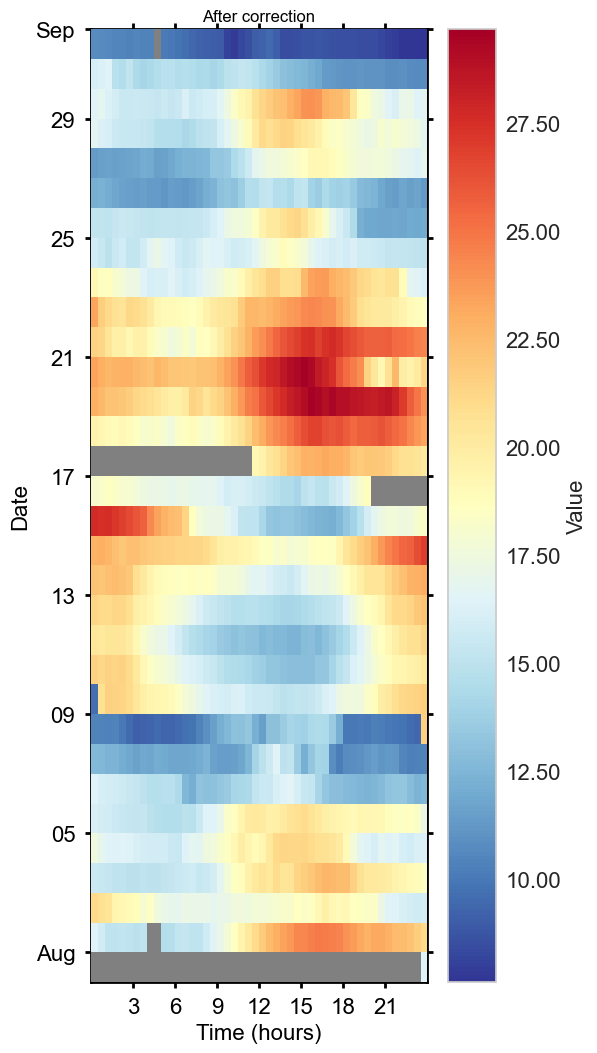

In [78]:
_swin = data_simple_merged['TA_T1_47_1'].copy()

# Identify shifted time period
_shifted_locs = (_swin.index >= '2012-08-09 00:00') & (_swin.index <= '2012-08-17 00:00')

# Shift SW_IN by 8.5 hours during shifted time period, create corrected time series
_swin_shifted = _swin[_shifted_locs].copy()
_swin_shifted = _swin_shifted.dropna()
_swin_shifted.index = _swin_shifted.index + pd.Timedelta(hours=0)
display(_swin_shifted)

_swin_corrected = _swin.copy()
_overwrite_locs = _swin_shifted.index
_swin_corrected[_shifted_locs] = np.nan  # Delete data during shifted time period
_swin_corrected[_overwrite_locs] = _swin_shifted  # Fill-in corrected data

# Plot with data around shifted dates
_show_locs = (_swin.index >= '2012-08-01 00:00') & (_swin.index <= '2012-09-01 00:00')
hm = dv.heatmapdatetime(series=_swin_corrected[_show_locs], title="After correction")
hm.show()


</br>

## Remove offset < 0 from `SW_IN`

In [ ]:
_swin = data_simple_merged['SW_IN_T1_47_1'].copy()
_swin_corrected = remove_radiation_zero_offset(series=_swin, lat=SITE_LAT, lon=SITE_LON, utc_offset=1, showplot=True)
data_simple_merged['SW_IN_T1_47_1'] = np.nan
data_simple_merged['SW_IN_T1_47_1'] = _swin_corrected

</br>

## Remove offset >100% from `RH`

In [ ]:
_rh = data_simple_merged['RH_T1_47_1'].copy()
_rh_corrected = remove_relativehumidity_offset(series=_rh, showplot=True)
data_simple_merged['RH_T1_47_1'] = np.nan
data_simple_merged['RH_T1_47_1'] = _rh_corrected

</br>

# Plot

In [ ]:
_plot_df = data_simple_merged[['TA_T1_47_1', 'RH_T1_47_1', 'SW_IN_T1_47_1', 'LW_IN_T1_47_1']].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

In [ ]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

In [ ]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# Save to file

In [ ]:
OUTNAME = "12.1_METEO_NOT-GAPFILLED_2004-2024"
OUTPATH = r""
filepath = save_parquet(filename=OUTNAME, data=data_simple_merged, outpath=OUTPATH)
data_simple_merged.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

</br>

# End of notebook.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

</br>

</br>

</br>

</br>

# Rename variables for merging and for use in EddyPro

In [ ]:
# renaming_dict = {
#     'LW_IN_F': 'Lwin_1_1_1',
#     'PPFD_IN': 'PPFD_1_1_1',
#     'RH': 'RH_1_1_1',
#     'SW_IN_F': 'Rg_1_1_1',
#     'TA_F': 'Ta_1_1_1',
#     'PA_F': 'Pa_1_1_1'
# }
# data_simple_fluxnet = data_simple_fluxnet.rename(columns=renaming_dict)
# data_simple_fluxnet

In [ ]:
# renaming_dict = {
#     'LW_IN_T1_2_1': 'Lwin_1_1_1',
#     'PPFD_IN_T1_2_2': 'PPFD_1_1_1',
#     'RH_T1_2_1': 'RH_1_1_1',
#     'SW_IN_T1_2_1': 'Rg_1_1_1',
#     'TA_T1_2_1': 'Ta_1_1_1',
#     'PA_GF1_0.9_1': 'Pa_1_1_1'
# }
# data_simple = data_simple.rename(columns=renaming_dict)
# data_simple

</br>

# **Gap-filling**

## Rg

In [ ]:
_df = pd.DataFrame()
_df['Rg_1_1_1'] = data_simple_merged[['Rg_1_1_1']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

In [ ]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Rg_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)

In [ ]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()

In [ ]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()

In [ ]:
observed = _df['Rg_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

In [ ]:
title="Short-wave incoming radiation"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## TA

In [ ]:
_df = pd.DataFrame()
_df['Rg_1_1_1_gfXG'] = data_simple_merged['Rg_1_1_1_gfXG'].copy()
_df['Ta_1_1_1'] = data_simple_merged['Ta_1_1_1'].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

In [ ]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Ta_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)

In [ ]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()

In [ ]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()

In [ ]:
observed = _df['Ta_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

In [ ]:
title="Air temperature"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## PPFD

In [ ]:
_df = pd.DataFrame()
_df['PPFD_1_1_1'] = data_simple_merged[['PPFD_1_1_1']].copy()
_df['Rg_1_1_1_gfXG'] = data_simple_merged[['Rg_1_1_1_gfXG']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

In [ ]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='PPFD_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)

In [ ]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()

In [ ]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()

In [ ]:
observed = _df['PPFD_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

In [ ]:
title="PPFD"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

</br>

# **Plots**

In [ ]:
_plot_df = data_simple_merged[['Lwin_1_1_1', 'PPFD_1_1_1', 'PPFD_1_1_1_gfXG', 'RH_1_1_1', 'Rg_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1', 'Ta_1_1_1_gfXG', 'Pa_1_1_1']].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

In [ ]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

In [ ]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# **Stats**

In [ ]:
data_simple_merged.describe()

</br>

# **Keep relevant columns**

In [ ]:
data_simple_merged.columns

In [ ]:
keepcols = ['Lwin_1_1_1', 'RH_1_1_1', 'Pa_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG']
data_simple_merged = data_simple_merged[keepcols].copy()
data_simple_merged

</br>

# **Add timestamp columns for EddyPro**

In [ ]:
# EddyPro needs two columns: date and time
data_simple_merged['date'] = data_simple_merged.index.date
data_simple_merged['date'] = data_simple_merged['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

data_simple_merged['time'] = data_simple_merged.index.time
data_simple_merged['time'] = data_simple_merged['time'].apply(lambda x: x.strftime('%H:%M'))

# Move date and time columns to start of dataframe
col = data_simple_merged.pop('date')
data_simple_merged.insert(0, col.name, col)
col = data_simple_merged.pop('time')
data_simple_merged.insert(1, col.name, col)

data_simple_merged

</br>

# **Add units for EddyPro input file**

In [ ]:
renaming_dict = {
    'date': ('date', 'yyyy-mm-dd'),
    'time': ('time', 'HH:MM'),
    'Lwin_1_1_1': ('Lwin_1_1_1', 'W+1m-2'),
    'PPFD_1_1_1_gfXG': ('PPFD_1_1_1', 'umol+1m-2s-1'),
    'RH_1_1_1': ('RH_1_1_1', '%'),
    'Rg_1_1_1_gfXG': ('Rg_1_1_1', 'W+1m-2'),
    'Ta_1_1_1_gfXG': ('Ta_1_1_1', 'C'),
    'Pa_1_1_1': ('Pa_1_1_1', 'kPa')
}
data_simple_merged = data_simple_merged.rename(columns=renaming_dict)
data_simple_merged.columns = pd.MultiIndex.from_tuples(data_simple_merged.columns)
data_simple_merged

</br>

# **Set missing values code** to -9999

In [ ]:
# EddyPro needs missing values as -9999
data_simple_merged = data_simple_merged.fillna(-9999)
data_simple_merged

</br>

# **Save to file**

In [ ]:
data_simple_merged.to_csv(OUTFILE, index=False)

</br>

# **End of notebook**.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

</br>

# (Bonus)

In [ ]:
# ta = data_simple_merged[('Ta_1_1_1', 'C')].copy()
# ta = TimestampSanitizer(data=ta).get()
# ta = ta.loc[ta.index.year > 2005].copy()
# means = ta.groupby(ta.index.year).mean()
# means

In [ ]:
# means.sort_values(ascending=False).head(5)

In [ ]:
# means.loc[means.index > 2014].mean()